# Group Project

Quang Duy Do, Jingjing Li, Wendy Li, Lucia Lu

### Introduction
The term “heart disease” refers to several types of heart conditions. The most common type of heart disease in the United States is coronary artery disease (CAD), which affects the blood flow to the heart. Decreased blood flow can cause a heart attack.
Many factors contribute to heart disease, including blood pressure and cholesterol levels. Age also has a potential influence on heart disease. Heart disease is primarily symptomatic when it occurs, but it can be prevented by everyday signs such as exercising for angina.

Too much LDL cholesterol in the blood causes plaque to build up in the arteries. The buildup cuts blood flow and leads to heart and blood vessel conditions. The LDL cholesterol level should be less than 130 mg/dL (3.4 mmol/L).

Angina pain happens when your heart muscle does not get as much oxygen-rich blood as it needs. An angina event does not cause permanent damage to the heart. However, your angina may turn into a heart attack if the cells in your heart do not get enough oxygen for too long and they start to die.

This project aims to predict a patient's likelihood of developing heart disease using factors such as age, cholesterol levels, and whether or not angina occurs with exercise.

In [3]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Preliminary exploratory data analysis:

As demonstrated below, we can read the data from web using read_csv() as the columns are separated by ",".

In [64]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"),
                           col_types = list("d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "f", "f", "d"))


# Replace "?" with NA
cleveland_data <- cleveland_data |>
  mutate_all(~if_else(. == "?", NA_real_, as.numeric(.)))


# Display the first few rows of the data
head(cleveland_data)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,1,1,0
67,1,4,160,286,0,2,108,1,1.5,2,2,2,2
67,1,4,120,229,0,2,129,1,2.6,2,3,3,1
37,1,3,130,250,0,0,187,0,3.5,3,1,2,0
41,0,2,130,204,0,2,172,0,1.4,1,1,2,0
56,1,2,120,236,0,0,178,0,0.8,1,1,2,0


In [19]:
#Split data into training and testing sets. Variable "num" is the number of diagnoses of heart disease- which
#is our target
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

head(cleveland_train)
head(cleveland_test)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,1,1,0
37,1,3,130,250,0,0,187,0,3.5,3,1,2,0
41,0,2,130,204,0,2,172,0,1.4,1,1,2,0
57,0,4,120,354,0,0,163,1,0.6,1,1,2,0
57,1,4,140,192,0,0,148,0,0.4,2,1,1,0
56,0,2,140,294,0,2,153,0,1.3,2,1,2,0


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
67,1,4,120,229,0,2,129,1,2.6,2,3,3,1
56,1,2,120,236,0,0,178,0,0.8,1,1,2,0
57,1,3,150,168,0,0,174,0,1.6,1,1,2,0
64,1,1,110,211,0,2,144,1,1.8,2,1,2,0
58,1,2,120,284,0,2,160,0,1.8,2,1,2,1
66,0,1,150,226,0,0,114,0,2.6,3,1,2,0


In [25]:
# Table showing the observation and percentage of numbers of diagnoses of heart diseases.

num_obs <- nrow(cleveland_train)

pre_num <- cleveland_train |>
    group_by(num) |>
    summarize (
    count = n(),
    percentage = n() / num_obs * 100)

pre_num

num,count,percentage
<dbl>,<int>,<dbl>
0,123,54.666667
1,41,18.222222
2,28,12.444444
3,25,11.111111
4,8,3.555556


In [31]:
# Examining the predictors


# Specify predictors
predictors <- c("age", "chol", "exang")


# Calculate the means of predictors in the training data
means_training <- colMeans(cleveland_train[, predictors], na.rm = TRUE)

# Display the means
means_training

# Summary of predictors in the training data for more details
summary_training <- summary(cleveland_train[, predictors])

# Display the summary
summary_training

age        chol       exang 
 54.2977778 247.4577778   0.3111111

      age            chol           exang       
 Min.   :29.0   Min.   :126.0   Min.   :0.0000  
 1st Qu.:48.0   1st Qu.:211.0   1st Qu.:0.0000  
 Median :55.0   Median :240.0   Median :0.0000  
 Mean   :54.3   Mean   :247.5   Mean   :0.3111  
 3rd Qu.:60.0   3rd Qu.:278.0   3rd Qu.:1.0000  
 Max.   :76.0   Max.   :564.0   Max.   :1.0000  

In [35]:
# Check for missing values. This is the number of missing values that we replaced "?" with "NA"
missing_values <- colSums(is.na(cleveland_train))
missing_values

age      sex       cp trestbps     chol      fbs  restecg  thalach 
       0        0        0        0        0        0        0        0 
   exang  oldpeak    slope       ca     thal      num 
       0        0        0        4        2        0

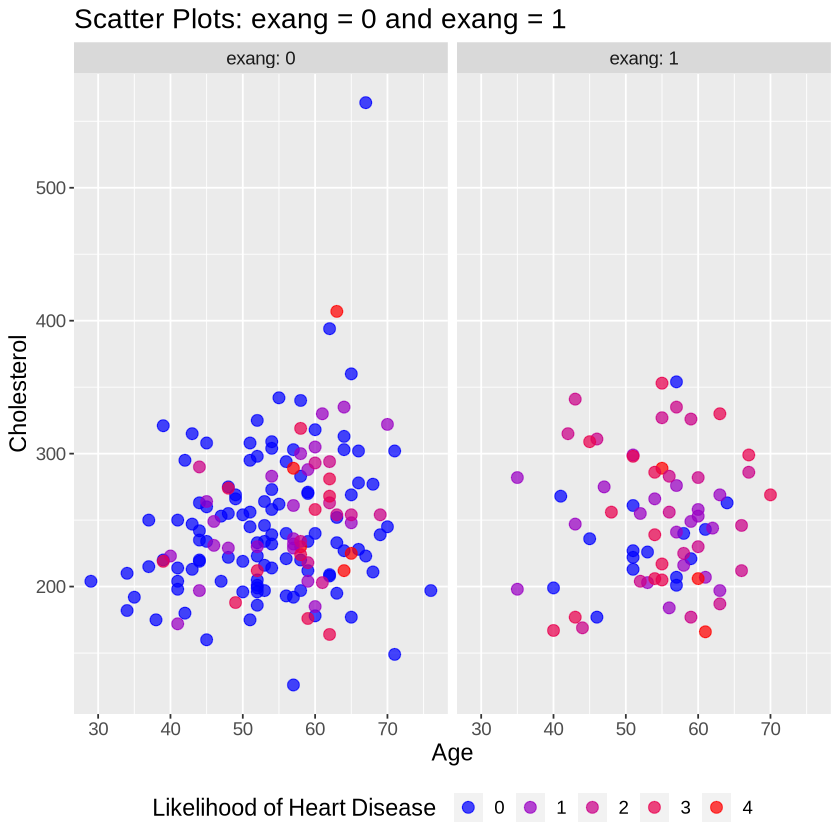

In [71]:
# Visualizing

# # Convert 'num' to numeric
cleveland_train$num <- as.numeric(cleveland_train$num)


# Create scatter plots with exang = 0 and exang = 1
scatter_plots <- ggplot(cleveland_train, aes(x = age, y = chol, color = num)) +
  geom_point(alpha = 0.72, size = 3) +
  labs(title = "Scatter Plots: exang = 0 and exang = 1",
       x = "Age",
       y = "Cholesterol",
       color = "Diaganoses of Heart Disease") +
  facet_grid(cols = vars(exang), labeller = label_both) +
scale_color_gradient(low = "blue", high = "red",  
                     guide = guide_legend(title = "Likelihood of Heart Disease")) +  # Use the same color for both levels
  theme(text = element_text(size = 14),  # Adjust text size
        legend.position = "bottom")  # Move legend to the bottom

# Display the scatter plots
scatter_plots

### Methods

We will conduct data analysis on the  age, cholesterol levels, exercise accompanied with angina, and diagnoses of heart disease columns. These variables correspond respectively to the columns "age", "chol", "exang", and "num". With these columns, we can investigate the relationship between each factor and the final result of having or not having a diagnosis of heart disease. 

To visualize our results, we will be plotting scatter plots of angina with exercise vs. age, and angina with exercise vs. cholesterol levels, using different colours to represent having or not having a diagnosis of heart disease. With this visualization, we can observe the relationship between age or cholesterol levels with angina during exercise, as well as any correlation these factors may have with heart disease diagnosis. 

First, we read the data into R from the URL provided for the data set. Next, we tidied the dataset by setting each column as a single variable, with its observations/values listed below the vector. We then divided our data set into 75% training data and 25% testing data to use for building our classifier. To better understand our data, we constructed a table demonstrating the percentage of numbers of diagnoses of heart diseases.

We decided to examine our predictors by calculating the mean of each predictor in the training data, as shown above. Lastly, we created preliminary scatterplots to better visualize and interpret our dataset. 

### Expected outcomes and significance

#### Expected outcomes:
We expected to find out how age, high or low cholesterol levels, and exercise-induced angina are related to the diagnosis of heart disease.

#### Impacts of the findings:

By identifying associations between the mentioned factors and heart disease, the classification model can be trained to better distinguish individuals with and without heart disease. This can lead to more accurate assessments and thus earlier intervention for heart disease. More importantly, the classification model reduces the time it takes to diagnose heart disease and greatly improves the efficiency of the medical system.

#### The possible questions that may be led in the future:

1. What other factors besides the variables in our study could constitute heart disease?
2. How specific age groups are associated with heart disease?
3. How do cholesterol levels change over time, and tracking their patterns helps diagnose heart disease?
4. How does the frequency of exercise-induced angina relate to the likelihood of a diagnosis of heart disease?
5. How accurate is the classification in a diagnosis of heart disease?